In [1]:
import pandas as pd
import numpy as np

In [66]:
import re
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb

In [19]:
pd.set_option('display.max_colwidth',100)

In [5]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [27]:
train.head()

,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,backers_count,final_status,name_len,desc_len,name_count,desc_count,keywords_len,keywords_count
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them too. so i thought i would suggest something for m...,20.0,drawing-for-dollars,False,US,USD,1241333999,1241334017,1240600507,1240602723,3,1,19,134,3,26,19,3
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in Residence in Kankakee Illinois,"I, Dereck Blackburn will be taking upon an incredible journey in the month of May 2009. I will b...",300.0,sponsor-dereck-blackburn-lostwars-artist-in-residence-in-kankakee-illinois,False,US,USD,1242429000,1242432018,1240960224,1240975592,2,0,76,137,10,25,74,10
2,kkst183622197,Mr. Squiggles,"So I saw darkpony's successfully funded drawing for dollars project and I thought """"""""""""""""""""""""""""...",30.0,mr-squiggles,False,US,USD,1243027560,1243027818,1242163613,1242164398,0,0,13,385,2,22,12,2
3,kkst597742710,Help me write my second novel.,Do your part to help out starving artists and help me write my second novel!\r\n\r\nI have just ...,500.0,help-me-write-my-second-novel,False,US,USD,1243555740,1243556121,1240963795,1240966730,18,1,30,131,6,24,29,6
4,kkst1913131122,Support casting my sculpture in bronze,"I'm nearing completion on a sculpture, currently titled """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...",2000.0,support-casting-my-sculpture-in-bronze,False,US,USD,1243769880,1243770317,1241177914,1241180541,1,0,38,384,6,18,38,6


In [8]:
train.dtypes

project_id                object
name                      object
desc                      object
goal                     float64
keywords                  object
disable_communication       bool
country                   object
currency                  object
deadline                   int64
state_changed_at           int64
created_at                 int64
launched_at                int64
backers_count              int64
final_status               int64
dtype: object

In [9]:
cols_to_use = ['name','desc']
len_feats = ['name_len','desc_len']
count_feats = ['name_count','desc_count']

for i in xrange(len(cols_to_use)):
    train[len_feats[i]] = train[cols_to_use[i]].apply(str).apply(len)
    test[len_feats[i]] = test[cols_to_use[i]].apply(str).apply(len)

In [17]:
train.head()

,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,backers_count,final_status,name_len,desc_len
0,kkst14...,drawin...,I like...,20.0,drawin...,False,US,USD,124133...,124133...,124060...,124060...,3,1,19,134
1,kkst14...,Sponso...,"I, Der...",300.0,sponso...,False,US,USD,124242...,124243...,124096...,124097...,2,0,76,137
2,kkst18...,Mr. Sq...,So I s...,30.0,mr-squ...,False,US,USD,124302...,124302...,124216...,124216...,0,0,13,385
3,kkst59...,Help m...,Do you...,500.0,help-m...,False,US,USD,124355...,124355...,124096...,124096...,18,1,30,131
4,kkst19...,Suppor...,I'm ne...,2000.0,suppor...,False,US,USD,124376...,124377...,124117...,124118...,1,0,38,384


In [23]:
train.name.head()

0                                                             drawing for dollars
1    Sponsor Dereck Blackburn (Lostwars) Artist in Residence in Kankakee Illinois
2                                                                   Mr. Squiggles
3                                                  Help me write my second novel.
4                                          Support casting my sculpture in bronze
Name: name, dtype: object

In [25]:
#train["name_count"]
train["name_count"] = train["name"].apply(str).apply(lambda x:len(x.split())) #train['name'].str.split().str.len()
train["desc_count"] = train["desc"].apply(str).apply(lambda x:len(x.split()))
test["name_count"] = test["name"].apply(str).apply(lambda x:len(x.split()))
test["desc_count"] = test["desc"].apply(str).apply(lambda x:len(x.split()))

In [26]:
train['keywords_len'] = train['keywords'].str.len()
train['keywords_count'] = train['keywords'].str.split('-').str.len()

test['keywords_len'] = test['keywords'].str.len()
test['keywords_count'] = test['keywords'].str.split('-').str.len()

In [29]:
time_columns = ["deadline","state_changed_at","launched_at","created_at"]

In [31]:
def convert_to_dollars(x,y):
    if y=="USD":
        return x
    elif y=="GBP":
        return x*1.28
    elif y=="CAD":
        return x*0.75
    elif y=="AUD":
        return x*0.76
    elif y=="EUR":
        return x*1.12
    elif y=="NZD":
        return x*0.73
    elif y=="SEK":
        return x*0.11
    elif y=="DKK":
        return x*0.15
    else:
        return x*0.12

In [32]:
train["goal_uniform"] = train.apply(lambda x:convert_to_dollars(x["goal"],x["currency"]),axis=1)
test["goal_uniform"] = test.apply(lambda x:convert_to_dollars(x["goal"],x["currency"]),axis=1)

In [34]:
train.goal_uniform = train.goal_uniform.apply(lambda x:np.log(x))
test.goal_uniform = test.goal_uniform.apply(lambda x:np.log(x))

In [35]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

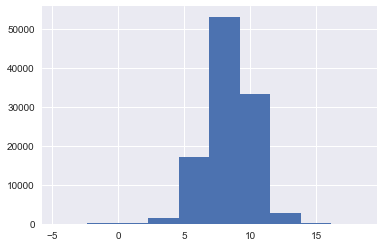

In [36]:
plt.hist(train.goal_uniform);

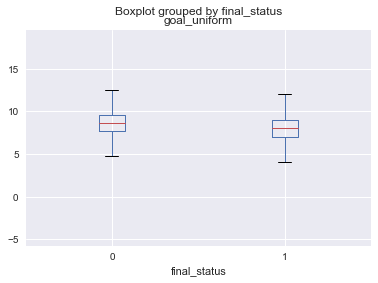

In [37]:
train.boxplot(by="final_status",column="goal_uniform")

In [39]:
train.created_at = pd.to_datetime(train.created_at,unit="s")
train.launched_at = pd.to_datetime(train.launched_at,unit="s")
train.deadline = pd.to_datetime(train.deadline,unit="s")
train.state_changed_at = pd.to_datetime(train.state_changed_at,unit="s")

In [40]:
test.created_at = pd.to_datetime(test.created_at,unit="s")
test.launched_at = pd.to_datetime(test.launched_at,unit="s")
test.deadline = pd.to_datetime(test.deadline,unit="s")
test.state_changed_at = pd.to_datetime(test.state_changed_at,unit="s")

In [44]:
train["diff_launched_deadline"] = train.deadline.sub(train.launched_at,axis=0)
train["diff_launched_created"] = train.launched_at.sub(train.created_at,axis=0)
train["diff_launched_deadline"] = train["diff_launched_deadline"].astype("timedelta64[D]")
train["diff_launched_created"] = train["diff_launched_created"].astype("timedelta64[D]")

In [48]:
test["diff_launched_deadline"] = test.deadline.sub(test.launched_at,axis=0)
test["diff_launched_created"] = test.launched_at.sub(test.created_at,axis=0)
test["diff_launched_deadline"] = test["diff_launched_deadline"].astype("timedelta64[D]")
test["diff_launched_created"] = test["diff_launched_created"].astype("timedelta64[D]")

In [50]:
train["diff_launched_deadline"] = np.log1p(train.diff_launched_deadline)
train["diff_launched_created"] = np.log1p(train.diff_launched_created)

In [51]:
test["diff_launched_deadline"] = np.log1p(test.diff_launched_deadline)
test["diff_launched_created"] = np.log1p(test.diff_launched_created)

### Text Cleaning 

In [54]:
def clean(word):
    temp = re.sub(pattern="(\W+)|(\d+)|(\s+)",repl=" ",string=word)
    temp = temp.lower()
    return temp

In [55]:
all_descriptions = pd.Series(train.desc.tolist() + test.desc.tolist()).astype(str)

In [58]:
all_descriptions.shape

(171594,)

In [59]:
all_descriptions = all_descriptions.map(clean)

In [61]:
all_descriptions.head()

0    i like drawing pictures and then i color them too so i thought i would suggest something for me ...
1    i dereck blackburn will be taking upon an incredible journey in the month of may   i will be tra...
2    so i saw darkpony s successfully funded drawing for dollars project and i thought that s fun i d...
3    do your part to help out starving artists and help me write my second novel i have just finished...
4    i m nearing completion on a sculpture currently titled un named man   which stands approximately...
dtype: object

In [67]:
stop = set(stopwords.words("english"))

In [70]:
all_descriptions = [[x for x in x.split() if x not in stop]for x in all_descriptions]

In [73]:
stemmer = SnowballStemmer(language="english")
all_descriptions = [[stemmer.stem(x) for x in x] for x in all_descriptions]
all_descriptions = [[x for x in x if len(x)>2] for x in all_descriptions]
all_descriptions = [" ".join(x) for x in all_descriptions]

In [75]:
all_descriptions[0:3]

[u'like draw pictur color thought would suggest someth draw someon want',
 u'dereck blackburn take upon incred journey month may travel hometown kankake',
 u'saw darkponi success fund draw dollar project thought fun drew guy call']

In [76]:
from sklearn.datasets import fetch_20newsgroups

In [82]:
cv = CountVectorizer(max_features=200)

In [83]:
temp = cv.fit_transform(all_descriptions).todense()

In [86]:
temp.shape

(171594, 200)

In [87]:
textDF = pd.DataFrame(temp)
textDF.rename(columns=lambda x:"variable_"+str(x),inplace=True)

In [88]:
textDF.head()

,variable_0,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,...,variable_190,variable_191,variable_192,variable_193,variable_194,variable_195,variable_196,variable_197,variable_198,variable_199
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
train_text = textDF[:train.shape[0]]
test_text = textDF[train.shape[0]:]

In [91]:
test_text.head()

,variable_0,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,...,variable_190,variable_191,variable_192,variable_193,variable_194,variable_195,variable_196,variable_197,variable_198,variable_199
108129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
108131,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108132,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
test_text.reset_index(drop=True,inplace=True)

In [93]:
test_text.head()

,variable_0,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,...,variable_190,variable_191,variable_192,variable_193,variable_194,variable_195,variable_196,variable_197,variable_198,variable_199
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
train.columns.tolist()

['project_id',
 'name',
 'desc',
 'goal',
 'keywords',
 'disable_communication',
 'country',
 'currency',
 'deadline',
 'state_changed_at',
 'created_at',
 'launched_at',
 'backers_count',
 'final_status',
 'name_len',
 'desc_len',
 'name_count',
 'desc_count',
 'keywords_len',
 'keywords_count',
 'goal_uniform',
 'diff_launched_deadline',
 'diff_launched_created']

In [95]:
cols_to_use = ['name_len','desc_len','keywords_len','name_count','desc_count','keywords_count','diff_launched_deadline','diff_launched_created','goal_uniform']

In [96]:
target = train.final_status

In [97]:
train = train.loc[:,cols_to_use]
test = test.loc[:,cols_to_use]

In [98]:
X_train = pd.concat([train,train_text],axis=1)
X_test = pd.concat([test,test_text],axis=1)

In [99]:
X_train.shape

(108129, 209)

In [100]:
X_test.shape

(63465, 209)

In [101]:
dtrain = xgb.DMatrix(data=X_train,label=target)
dtest = xgb.DMatrix(data=X_test)

In [103]:
params = {
    'objective':'binary:logistic',
    'eval_metric':'error',
    'eta':0.025,
    'max_depth':6,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':5
}

In [104]:
bst = xgb.cv(params,dtrain,num_boost_round=1000,early_stopping_rounds=40,nfold=5L,verbose_eval=100)

[0]	train-error:0.313008+0.000595013	test-error:0.316412+0.00413383
[100]	train-error:0.299759+0.00041209	test-error:0.30646+0.00199085
[200]	train-error:0.292317+0.000491016	test-error:0.301346+0.00229752
[300]	train-error:0.286571+0.000610928	test-error:0.298701+0.00191393
[400]	train-error:0.281988+0.000563624	test-error:0.296388+0.00182255
[500]	train-error:0.277951+0.000531227	test-error:0.294761+0.0019936
[600]	train-error:0.274522+0.00057007	test-error:0.294529+0.00229731


In [105]:
type(X_train)

pandas.core.frame.DataFrame

In [106]:
X_train.to_csv("modified_train.csv",index=False)
X_test.to_csv("modified_test.csv",index=False)

In [107]:
import gc

In [108]:
gc.collect()

59

In [118]:
bst_train = xgb.train(params, dtrain, num_boost_round=1500)

In [119]:
p_test = bst_train.predict(dtest)

In [120]:
p_test

array([ 0.22400743,  0.08859063,  0.13623972, ...,  0.20388927,
        0.09101537,  0.32656053], dtype=float32)

In [115]:
tempdf = pd.read_csv("data/test.csv")

In [121]:
sub = pd.DataFrame()
sub['project_id'] = tempdf['project_id']
sub['final_status'] = p_test
sub['final_status'] = [1 if x > 0.5 else 0 for x in sub['final_status']]
sub.to_csv("sol3.csv",index=False)